In [2]:
import os 
def current_path():
    print("Current working directory before")
    print(os.getcwd())
    print()
current_path()
os.chdir('../')
current_path()

Current working directory before
/app/alphafold/extra

Current working directory before
/app/alphafold



In [9]:
import collections
import copy
from concurrent import futures
import json
import random

from urllib import request
from matplotlib import gridspec

import matplotlib.pyplot as plt
import numpy as np
import py3Dmol


from alphafold.model import model
from alphafold.model import config
from alphafold.model import data


from alphafold.data import feature_processing
from alphafold.data import msa_pairing
from alphafold.data import pipeline
from alphafold.data import pipeline_multimer
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

from alphafold.relax import relax
from alphafold.relax import utils

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

PLDDT_BANDS = [(0, 50, '#FF7D45'),
               (50, 70, '#FFDB13'),
               (70, 90, '#65CBF3'),
               (90, 100, '#0053D6')]

from alphafold.notebooks import notebook_utils

In [15]:
# prediction = model_runner.predict(processed_feature_dict, random_seed=random.randrange(sys.maxsize))
import pickle 
with open('./extra/result_model_2_multimer_v2_pred_1.pkl', 'rb') as f:
  prediction = pickle.load(f)
  for keys in prediction:
    print(keys) 
# print(prediction['plddt'])
print('--------------------------------------')
with open('./extra/features.pkl', 'rb') as f:
    processed_feature_dict = pickle.load(f)
    for keys in processed_feature_dict:
        print(keys)

distogram
experimentally_resolved
masked_msa
predicted_aligned_error
predicted_lddt
structure_module
plddt
aligned_confidence_probs
max_predicted_aligned_error
ptm
iptm
ranking_confidence
--------------------------------------
aatype
residue_index
seq_length
msa
num_alignments
template_aatype
template_all_atom_mask
template_all_atom_positions
asym_id
sym_id
entity_id
deletion_matrix
deletion_mean
all_atom_mask
all_atom_positions
assembly_num_chains
entity_mask
num_templates
cluster_bias_mask
bert_mask
seq_mask
msa_mask


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

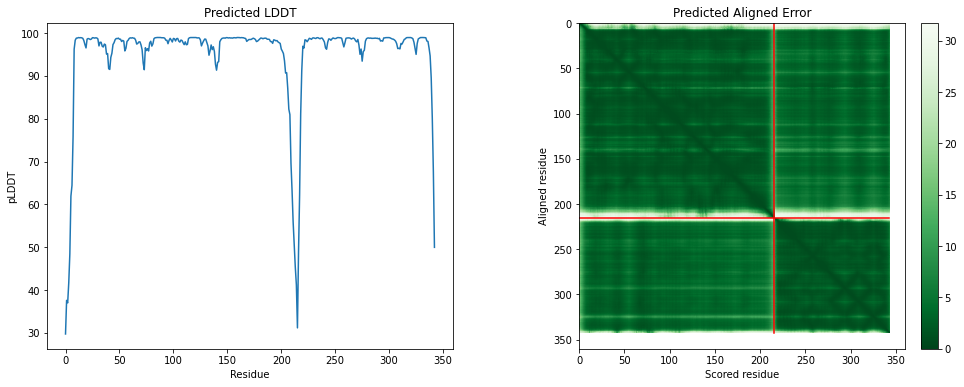

In [22]:
# plddts = {}
# ranking_confidences = {}
# pae_outputs = {}
# unrelaxed_proteins = {}

model_type_to_use = notebook_utils.ModelType.MULTIMER

mean_plddt = prediction['plddt'].mean()

# if model_type_to_use == notebook_utils.ModelType.MONOMER:
#     if 'predicted_aligned_error' in prediction:
#         pae_outputs[model_name] = (prediction['predicted_aligned_error'],
#                                    prediction['max_predicted_aligned_error'])
#     else:
#         # Monomer models are sorted by mean pLDDT. Do not put monomer pTM models here as they
#         # should never get selected.
#         ranking_confidences[model_name] = prediction['ranking_confidence']
#         plddts[model_name] = prediction['plddt']
# elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
#     # Multimer models are sorted by pTM+ipTM.
#     ranking_confidences[model_name] = prediction['ranking_confidence']
#     plddts[model_name] = prediction['plddt']
#     pae_outputs[model_name] = (prediction['predicted_aligned_error'],
#                              prediction['max_predicted_aligned_error'])

# Set the b-factors to the per-residue plddt.
final_atom_mask = prediction['structure_module']['final_atom_mask']
b_factors = prediction['plddt'][:, None] * final_atom_mask
unrelaxed_protein = protein.from_prediction(
    processed_feature_dict,
    prediction,
    b_factors=b_factors,
    remove_leading_feature_dimension=(model_type_to_use == notebook_utils.ModelType.MONOMER))

# unrelaxed_proteins[model_name] = unrelaxed_protein

# # Delete unused outputs to save memory.
# del model_runner
# del params
# del prediction
# pbar.update(n=1)

# --- AMBER relax the best model ---

# Find the best model according to the mean pLDDT.
# best_model_name = max(ranking_confidences.keys(), key=lambda x: ranking_confidences[x])
run_relax = False
if run_relax:
    # pbar.set_description(f'AMBER relaxation')
    amber_relaxer = relax.AmberRelaxation(
        max_iterations=0,
        tolerance=2.39,
        stiffness=10.0,
        exclude_residues=[],
        max_outer_iterations=3,
        use_gpu=True)
    # relaxed_pdb, _, _ = amber_relaxer.process(prot=unrelaxed_proteins[best_model_name])
    relaxed_pdb, _, _ = amber_relaxer.process(prot=unrelaxed_protein)
else:
    print('Warning: Running without the relaxation stage.')
    # relaxed_pdb = protein.to_pdb(unrelaxed_proteins[best_model_name])
    relaxed_pdb = protein.to_pdb(unrelaxed_protein)
    
# pbar.update(n=1)  # Finished AMBER relax.

# Construct multiclass b-factors to indicate confidence bands
# 0=very low, 1=low, 2=confident, 3=very high
# Color bands for visualizing plddt
PLDDT_BANDS = [(0, 50, '#FF7D45'),
               (50, 70, '#FFDB13'),
               (70, 90, '#65CBF3'),
               (90, 100, '#0053D6')]

banded_b_factors = []
# for plddt in plddts[best_model_name]:
for plddt in prediction['plddt']:
    for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
        if plddt >= min_val and plddt <= max_val:
            banded_b_factors.append(idx)
            break
banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
to_visualize_pdb = utils.overwrite_b_factors(relaxed_pdb, banded_b_factors)

output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)
# Write out the prediction
pred_output_path = os.path.join(output_dir, 'selected_prediction.pdb')
with open(pred_output_path, 'w') as f:
    f.write(relaxed_pdb)


# --- Visualise the prediction & confidence ---
# show_sidechains = True
show_sidechains = False
def plot_plddt_legend():
    """Plots the legend for pLDDT."""
    thresh = ['Very low (pLDDT < 50)',
            'Low (70 > pLDDT > 50)',
            'Confident (90 > pLDDT > 70)',
            'Very high (pLDDT > 90)']

    colors = [x[2] for x in PLDDT_BANDS]

    plt.figure(figsize=(2, 2))
    for c in colors:
        plt.bar(0, 0, color=c)
    plt.legend(thresh, frameon=False, loc='center', fontsize=20)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.title('Model Confidence', fontsize=20, pad=20)
    return plt

# Show the structure coloured by chain if the multimer model has been used.
if model_type_to_use == notebook_utils.ModelType.MULTIMER:
    multichain_view = py3Dmol.view(width=800, height=600)
    multichain_view.addModelsAsFrames(to_visualize_pdb)
    multichain_style = {'cartoon': {'colorscheme': 'chain'}}
    multichain_view.setStyle({'model': -1}, multichain_style)
    multichain_view.zoomTo()
    multichain_view.show()

# Color the structure by per-residue pLDDT
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(to_visualize_pdb)
style = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}
if show_sidechains:
    style['stick'] = {}
view.setStyle({'model': -1}, style)
view.zoomTo()

grid = GridspecLayout(1, 2)
out = Output()
with out:
    view.show()
grid[0, 0] = out

out = Output()
with out:
    plot_plddt_legend().show()
grid[0, 1] = out

display.display(grid)

# Display pLDDT and predicted aligned error (if output by the model).
# if pae_outputs:
if True:
    num_plots = 2
else:
    num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
# plt.plot(plddts[best_model_name])
plt.plot(prediction['plddt'])
plt.title('Predicted LDDT')
plt.xlabel('Residue')
plt.ylabel('pLDDT')

if num_plots == 2:
    plt.subplot(1, 2, 2)
    # pae, max_pae = list(pae_outputs.values())[0]
    pae, max_pae = prediction['predicted_aligned_error'], prediction['max_predicted_aligned_error']
    plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
    plt.colorbar(fraction=0.046, pad=0.04)

    # Display lines at chain boundaries.
    # best_unrelaxed_prot = unrelaxed_proteins[best_model_name]
    best_unrelaxed_prot = unrelaxed_protein
    total_num_res = best_unrelaxed_prot.residue_index.shape[-1]
    chain_ids = best_unrelaxed_prot.chain_index
    for chain_boundary in np.nonzero(chain_ids[:-1] - chain_ids[1:]):
        if chain_boundary.size:
            plt.plot([0, total_num_res], [chain_boundary, chain_boundary], color='red')
            plt.plot([chain_boundary, chain_boundary], [0, total_num_res], color='red')

    plt.title('Predicted Aligned Error')
    plt.xlabel('Scored residue')
    plt.ylabel('Aligned residue')

# Save the predicted aligned error (if it exists).
# pae_output_path = os.path.join(output_dir, 'predicted_aligned_error.json')
# if pae_outputs:
#     # Save predicted aligned error in the same format as the AF EMBL DB.
#     pae_data = notebook_utils.get_pae_json(pae=pae, max_pae=max_pae.item())
#     with open(pae_output_path, 'w') as f:
#         f.write(pae_data)

# --- Download the predictions ---
# !zip -q -r {output_dir}.zip {output_dir}
# files.download(f'{output_dir}.zip')